In [1]:
%matplotlib inline
import my_RNN
import torch
from d2l import torch as d2l

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time)
# d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [3]:
tau = 8
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, num_steps, n_train = 16,8,600
train_iter,vocab = my_RNN.load_x_data(x[:n_train],batch_size,num_steps),1

In [5]:
def get_params(vocab,num_hiddens):
    num_inputs = num_outputs = vocab

    def normal(shape):
        return torch.randn(size=shape)*0.01
    
    #隐藏层参数
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens)
    #输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs)
    #附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [6]:
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    #X的形状batch_size x 1
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H,W_hh) + b_h)
        Y = torch.mm(H,W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=1),(H,)

In [7]:
def init_rnn_state(batch_size, num_hiddens):
    return (torch.zeros((batch_size, num_hiddens)), )

In [8]:
num_hiddens = 32
net = my_RNN.RNNModelScratch(vocab,num_hiddens,get_params,
                             init_rnn_state,rnn)

In [9]:
ls = torch.tensor([1.0,2.0,3.0],dtype=torch.float32)
my_RNN.predict(ls,5,net,vocab)

[tensor(1.),
 tensor(2.),
 tensor(3.),
 tensor([[0.0009]], grad_fn=<CatBackward0>),
 tensor([[4.0201e-05]], grad_fn=<CatBackward0>),
 tensor([[-1.2025e-06]], grad_fn=<CatBackward0>),
 tensor([[-2.3479e-07]], grad_fn=<CatBackward0>),
 tensor([[1.4170e-08]], grad_fn=<CatBackward0>)]

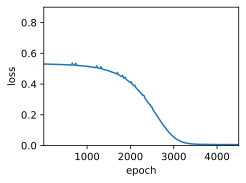

In [10]:
num_epochs, lr = 4500, 1e-3
my_RNN.train(net, train_iter, vocab, lr, num_epochs)


In [11]:
preds = []
for pred in features: 
    preds.append(my_RNN.predict(pred,1,net,vocab)[-1])
preds = torch.tensor(preds)


In [12]:
len(preds)

992

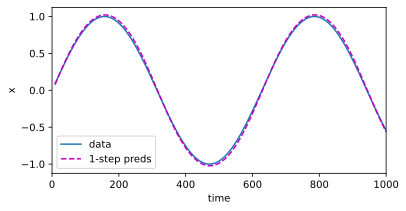

In [13]:
d2l.plot([time[tau:],time[tau:]],[labels,preds],xlim=[0,1000] ,
         xlabel='time',ylabel='x',legend=['data','1-step preds'],
        figsize=(6, 3))

## 多步预测

In [14]:
len(x)

1000

C:\Users\zz\AppData\Local\Temp\ipykernel_5024\887080390.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(multistep_preds[i-tau:i],dtype=torch.float32),1,net,vocab)[-1]
C:\Users\zz\AppData\Local\Temp\ipykernel_5024\887080390.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x.detach(),torch.tensor(preds,dtype=torch.float32).detach(),


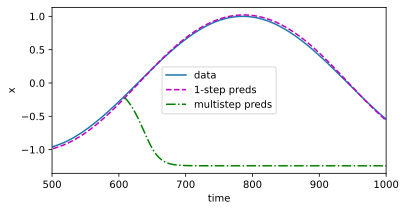

In [15]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i] = my_RNN.predict(
        torch.tensor(multistep_preds[i-tau:i],dtype=torch.float32),1,net,vocab)[-1]
d2l.plot([time,time[tau:],time[n_train+tau:]],
         [x.detach(),torch.tensor(preds,dtype=torch.float32).detach(),
          multistep_preds[n_train+tau:].detach()],'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[500, 1000], figsize=(6, 3))

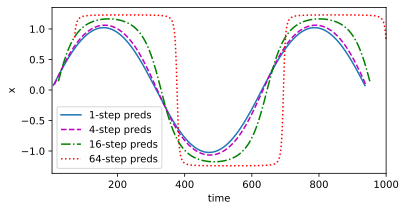

In [16]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(features.shape[0]):
    for j in range(tau, tau + max_steps):
        features[i, j] = my_RNN.predict(features[i, j - tau:j],1,net,vocab)[-1]


steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))